In [64]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", module="IPython")

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

print(f"Root dir: {root_dir}")

# Add the root directory to the `PYTHONPATH` 
if root_dir not in sys.path:
    sys.path.append(root_dir)
    print(f"Added the following directory to the PYTHONPATH: {root_dir}")

# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Root dir: /Users/zhangman/Documents/25_p2/scalable/lab/mlfs-book
HopsworksSettings initialized!


<span style="font-width:bold; font-size: 3rem; color:#333;">- Part 01: Feature Backfill for Air Quality Data</span>


## 🗒️ You have the following tasks
1. Choose an Air Quality Sensor
2. Update the country, city, and street information to point to YOUR chosen Air Quality Sensor
3. Download historical measures for your Air Quality Sensor as a CSV file
4. Update the path of the CSV file in this notebook to point to the one that you downloaded
5. Create an account on www.hopsworks.ai and get your HOPSWORKS_API_KEY
6. Run this notebook



### <span style='color:#ff5f27'> 📝 Imports

In [65]:
import datetime
import requests
import pandas as pd
import hopsworks
from mlfs.airquality import util
import datetime
from pathlib import Path
import json
import re
import os
import warnings
warnings.filterwarnings("ignore")

## Hopsworks API Key
You need to have registered an account on app.hopsworks.ai.

Save the HOPSWORKS_API_KEY  to ~/.env file in the root directory of your project

 * mv .env.example .env
 * edit .env

In the .env file, update HOPSWORKS_API_KEY:

`HOPSWORKS_API_KEY="put API KEY value in this string"`


In [66]:
project = hopsworks.login()

2025-11-14 22:49:25,578 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-14 22:49:25,609 INFO: Initializing external client
2025-11-14 22:49:25,610 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-14 22:49:27,118 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1296532


## <span style='color:#ff5f27'> 🌍 STEP 4: Get the AQICN_URL and API key. Enter country, city, street names for your Sensor.</span>

You can find your __AQICN_URL__ if you scroll down the webpage for your sensor - it is the URL inside the redbox here.
You shouldn't include the last part of the url - "/?token=\__YOUR_TOKEN\__". 
It is bad practice to save TOKENs (aka API KEYs) in your source code - you might make it public if you check that code into Github!
We will fill in the token later by saving the AQICN_API_KEY as a secret in Hopsworks.

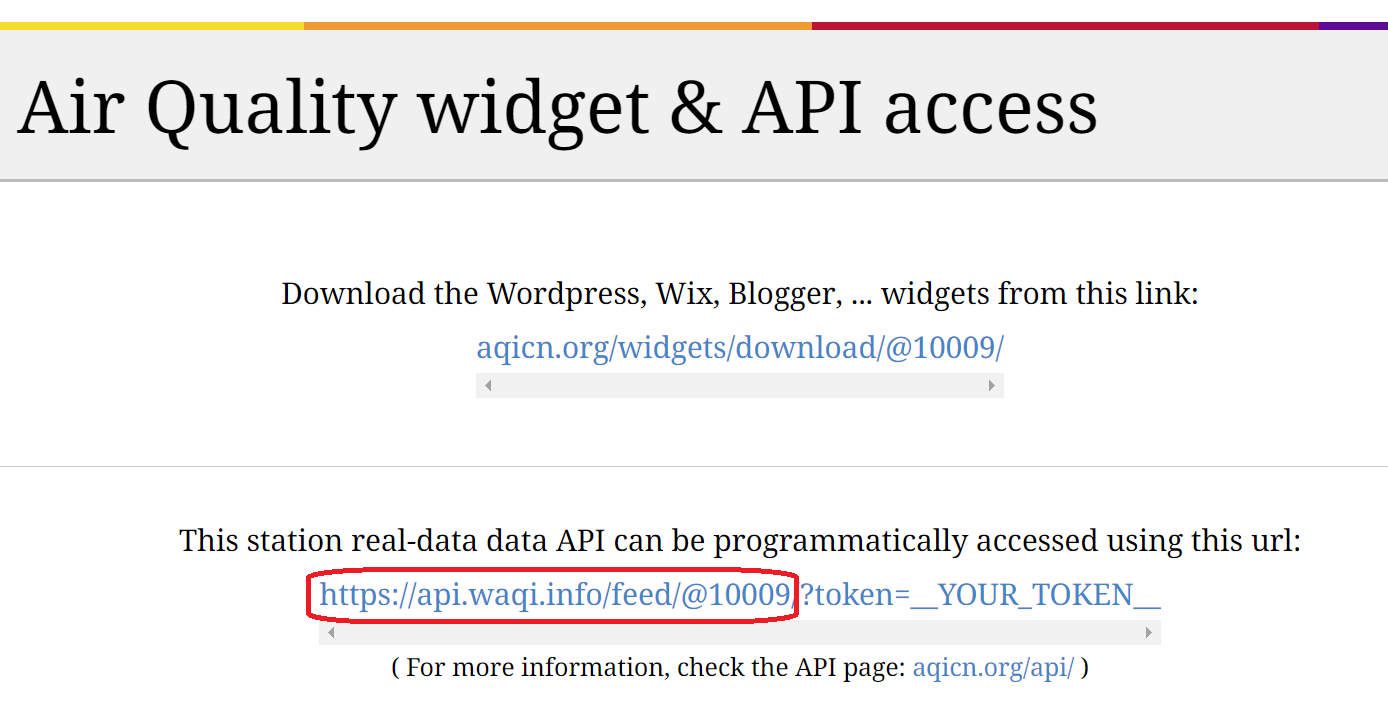


In [67]:
secret_value_list={
  "sensor1": {
    "country": "unitedkingdom",
    "city": "london",
    "street": "london",
    "aqicn_url": "https://api.waqi.info/feed/@5724",
    "csv_file": "/data/air-quality-data.csv",
    "latitude":"51.50735096",
    "longitude": "-0.1277583",
  },
  "sensor2": {
    "country": "unitedkingdom",
    "city": "londonboroughofwandsworth",
    "street": "nineelmslane",
    "aqicn_url": "https://api.waqi.info/feed/A516589",
    "csv_file": "/data/air-quality-data-2.csv",
    "latitude":"51.50735096",
    "longitude": "-0.1277583",
  },
  "sensor3": {
    "country": "unitedkingdom",
    "city": "londonboroughofwandsworth",
    "street": "batterseaparkroad",
    "aqicn_url": "https://api.waqi.info/feed/A516559/",
    "csv_file": "/data/air-quality-data-3.csv",
    "latitude":"51.50735096",
    "longitude": "-0.1277583",
  }
}
secret_str = json.dumps(secret_value_list)

secrets = hopsworks.get_secrets_api()
# Replace any existing secret with the new value
secret = secrets.get_secret("SENSOR_LOCATION_JSON")
if secret is not None:
    secret.delete()
    print("Replacing existing SENSOR_LOCATION_JSON")

secrets.create_secret("SENSOR_LOCATION_JSON", secret_str)

today = datetime.date.today()
secrets = hopsworks.get_secrets_api()
all_locations = json.loads(secrets.get_secret("SENSOR_LOCATION_JSON").value)
secret_value=all_locations["sensor3"]
country = secret_value["country"]
city = secret_value["city"]
street = secret_value["street"]
aqicn_url = secret_value["aqicn_url"]
csv_file_name = secret_value["csv_file"]
csv_file = f"{root_dir}{csv_file_name}"
util.check_file_path(csv_file)

AQICN_API_KEY = settings.AQICN_API_KEY.get_secret_value() 
print(f"Found AQICN_API_KEY: {AQICN_API_KEY}")


try:
    aq_today_df = util.get_pm25(aqicn_url, country, city, street, today, AQICN_API_KEY)
except hopsworks.RestAPIError:
    print("It looks like the AQICN_API_KEY doesn't work for your sensor. Is the API key correct? Is the sensor URL correct?")

aq_today_df.head()

Replacing existing SENSOR_LOCATION_JSON
Secret created successfully, explore it at https://c.app.hopsworks.ai:443/account/secrets
File successfully found at the path: /Users/zhangman/Documents/25_p2/scalable/lab/mlfs-book/data/air-quality-data-3.csv
Found AQICN_API_KEY: 3e6104ddc2479da9ec9bf4ef42c6bd008c127592


,pm25,country,city,street,date,url
0,54.0,unitedkingdom,londonboroughofwandsworth,batterseaparkroad,2025-11-14,https://api.waqi.info/feed/A516559/


In [68]:
# If this API call fails (it fails in a github action), then set longitude and latitude explicitly - comment out next line
# latitude, longitude = util.get_city_coordinates(city)
# Uncomment this if API call to get longitude and latitude
latitude = "51.50735096"
longitude = "-0.1277583"


print(f"Found AQICN_API_KEY: {AQICN_API_KEY}")

secrets = hopsworks.get_secrets_api()
# Replace any existing secret with the new value
secret = secrets.get_secret("AQICN_API_KEY")
if secret is not None:
    secret.delete()
    print("Replacing existing AQICN_API_KEY")

secrets.create_secret("AQICN_API_KEY", AQICN_API_KEY)

Found AQICN_API_KEY: 3e6104ddc2479da9ec9bf4ef42c6bd008c127592
Replacing existing AQICN_API_KEY
Secret created successfully, explore it at https://c.app.hopsworks.ai:443/account/secrets


Secret('AQICN_API_KEY', 'PRIVATE')

### Validate that the AQICN_API_KEY you added earlier works

The cell below should print out something like:

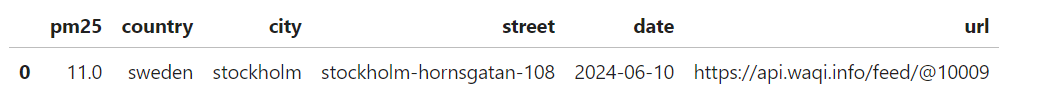

In [69]:
try:
    aq_today_df = util.get_pm25(aqicn_url, country, city, street, today, AQICN_API_KEY)
except hopsworks.RestAPIError:
    print("It looks like the AQICN_API_KEY doesn't work for your sensor. Is the API key correct? Is the sensor URL correct?")

aq_today_df.head()

,pm25,country,city,street,date,url
0,54.0,unitedkingdom,londonboroughofwandsworth,batterseaparkroad,2025-11-14,https://api.waqi.info/feed/A516559/


## <span style='color:#ff5f27'> 🌍 STEP 5: Read your CSV file into a DataFrame </span>

The cell below will read up historical air quality data as a CSV file into a Pandas DataFrame

In [71]:
df = pd.read_csv(csv_file,  parse_dates=['date'], skipinitialspace=True)
df

,date,min,max,median,q1,q3,stdev,count
0,2024-12-10 00:00:00+00:00,1.78,3.83,2.96,2.57,3.07,0.537,10
1,2024-12-11 00:00:00+00:00,1.47,10.32,5.60,2.60,8.36,2.927,24
2,2024-12-12 00:00:00+00:00,2.14,31.24,14.36,10.09,18.55,7.710,24
3,2024-12-13 00:00:00+00:00,14.65,34.40,27.12,24.54,32.09,5.665,24
4,2024-12-14 00:00:00+00:00,2.31,32.60,12.45,5.75,26.29,10.366,24
...,...,...,...,...,...,...,...,...
331,2025-11-10 00:00:00+00:00,2.12,4.93,3.09,2.64,3.54,0.737,24
332,2025-11-11 00:00:00+00:00,1.82,4.14,3.50,2.61,3.64,0.682,24
333,2025-11-12 00:00:00+00:00,3.08,8.05,4.14,3.45,6.86,1.850,24
334,2025-11-13 00:00:00+00:00,3.58,19.96,5.22,4.36,7.47,4.011,24


## <span style='color:#ff5f27'> 🌍 STEP 6: Data cleaning</span>


### Rename columns if needed and drop unneccessary columns

We want to have a DataFrame with 2 columns - `date` and `pm25` after this cell below:

## Check the data types for the columns in your DataFrame

 * `date` should be of type   datetime64[ns] 
 * `pm25` should be of type float64

In [72]:
if "median" in df.columns:
    df = df.rename(columns={"median": "pm25"})
df_aq = df[['date', 'pm25']]
df_aq['pm25'] = df_aq['pm25'].astype('float32')
df_aq = df_aq.sort_values('date')
df_aq['pm25_lag1'] = df_aq['pm25'].shift(1).astype('float32')
df_aq['pm25_lag2'] = df_aq['pm25'].shift(2).astype('float32')
df_aq['pm25_lag3'] = df_aq['pm25'].shift(3).astype('float32')
df_aq['pm25_lagged'] = df_aq['pm25'].rolling(3).mean().astype('float32')
df_aq

,date,pm25,pm25_lag1,pm25_lag2,pm25_lag3,pm25_lagged
0,2024-12-10 00:00:00+00:00,2.960000,NaN,NaN,NaN,NaN
1,2024-12-11 00:00:00+00:00,5.600000,2.960000,NaN,NaN,NaN
2,2024-12-12 00:00:00+00:00,14.360000,5.600000,2.96,NaN,7.640000
3,2024-12-13 00:00:00+00:00,27.120001,14.360000,5.60,2.96,15.693334
4,2024-12-14 00:00:00+00:00,12.450000,27.120001,14.36,5.60,17.976667
...,...,...,...,...,...,...
331,2025-11-10 00:00:00+00:00,3.090000,4.920000,4.54,9.89,4.183333
332,2025-11-11 00:00:00+00:00,3.500000,3.090000,4.92,4.54,3.836667
333,2025-11-12 00:00:00+00:00,4.140000,3.500000,3.09,4.92,3.576667
334,2025-11-13 00:00:00+00:00,5.220000,4.140000,3.50,3.09,4.286666


In [73]:
# Cast the pm25 column to be a float32 data type
df_aq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   date         336 non-null    datetime64[ns, UTC]
 1   pm25         336 non-null    float32            
 2   pm25_lag1    335 non-null    float32            
 3   pm25_lag2    334 non-null    float32            
 4   pm25_lag3    333 non-null    float32            
 5   pm25_lagged  334 non-null    float32            
dtypes: datetime64[ns, UTC](1), float32(5)
memory usage: 9.3 KB


## <span style='color:#ff5f27'> 🌍 STEP 7: Drop any rows with missing data </span>
It will make the model training easier if there is no missing data in the rows, so we drop any rows with missing data.

In [74]:
df_aq.dropna(inplace=True)
df_aq

,date,pm25,pm25_lag1,pm25_lag2,pm25_lag3,pm25_lagged
3,2024-12-13 00:00:00+00:00,27.120001,14.360000,5.600000,2.960000,15.693334
4,2024-12-14 00:00:00+00:00,12.450000,27.120001,14.360000,5.600000,17.976667
5,2024-12-15 00:00:00+00:00,3.410000,12.450000,27.120001,14.360000,14.326667
6,2024-12-16 00:00:00+00:00,1.210000,3.410000,12.450000,27.120001,5.690000
7,2024-12-17 00:00:00+00:00,9.360000,1.210000,3.410000,12.450000,4.660000
...,...,...,...,...,...,...
331,2025-11-10 00:00:00+00:00,3.090000,4.920000,4.540000,9.890000,4.183333
332,2025-11-11 00:00:00+00:00,3.500000,3.090000,4.920000,4.540000,3.836667
333,2025-11-12 00:00:00+00:00,4.140000,3.500000,3.090000,4.920000,3.576667
334,2025-11-13 00:00:00+00:00,5.220000,4.140000,3.500000,3.090000,4.286666


## <span style='color:#ff5f27'> 🌍 STEP 8: Add country, city, street, url to the DataFrame </span>

Your CSV file may have many other air quality measurement columns. We will only work with the `pm25` column.

We add the columns for the country, city, and street names that you changed for your Air Quality sensor.

We also want to make sure the `pm25` column is a float32 data type.

In [75]:
# Your sensor may have columns we won't use, so only keep the date and pm25 columns
# If the column names in your DataFrame are different, rename your columns to `date` and `pm25`
df_aq['country']=country
df_aq['city']=city
df_aq['street']=street
df_aq['url']=aqicn_url
df_aq

,date,pm25,pm25_lag1,pm25_lag2,pm25_lag3,pm25_lagged,country,city,street,url
3,2024-12-13 00:00:00+00:00,27.120001,14.360000,5.600000,2.960000,15.693334,unitedkingdom,londonboroughofwandsworth,batterseaparkroad,https://api.waqi.info/feed/A516559/
4,2024-12-14 00:00:00+00:00,12.450000,27.120001,14.360000,5.600000,17.976667,unitedkingdom,londonboroughofwandsworth,batterseaparkroad,https://api.waqi.info/feed/A516559/
5,2024-12-15 00:00:00+00:00,3.410000,12.450000,27.120001,14.360000,14.326667,unitedkingdom,londonboroughofwandsworth,batterseaparkroad,https://api.waqi.info/feed/A516559/
6,2024-12-16 00:00:00+00:00,1.210000,3.410000,12.450000,27.120001,5.690000,unitedkingdom,londonboroughofwandsworth,batterseaparkroad,https://api.waqi.info/feed/A516559/
7,2024-12-17 00:00:00+00:00,9.360000,1.210000,3.410000,12.450000,4.660000,unitedkingdom,londonboroughofwandsworth,batterseaparkroad,https://api.waqi.info/feed/A516559/
...,...,...,...,...,...,...,...,...,...,...
331,2025-11-10 00:00:00+00:00,3.090000,4.920000,4.540000,9.890000,4.183333,unitedkingdom,londonboroughofwandsworth,batterseaparkroad,https://api.waqi.info/feed/A516559/
332,2025-11-11 00:00:00+00:00,3.500000,3.090000,4.920000,4.540000,3.836667,unitedkingdom,londonboroughofwandsworth,batterseaparkroad,https://api.waqi.info/feed/A516559/
333,2025-11-12 00:00:00+00:00,4.140000,3.500000,3.090000,4.920000,3.576667,unitedkingdom,londonboroughofwandsworth,batterseaparkroad,https://api.waqi.info/feed/A516559/
334,2025-11-13 00:00:00+00:00,5.220000,4.140000,3.500000,3.090000,4.286666,unitedkingdom,londonboroughofwandsworth,batterseaparkroad,https://api.waqi.info/feed/A516559/


In [76]:
df_aq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 3 to 335
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   date         333 non-null    datetime64[ns, UTC]
 1   pm25         333 non-null    float32            
 2   pm25_lag1    333 non-null    float32            
 3   pm25_lag2    333 non-null    float32            
 4   pm25_lag3    333 non-null    float32            
 5   pm25_lagged  333 non-null    float32            
 6   country      333 non-null    object             
 7   city         333 non-null    object             
 8   street       333 non-null    object             
 9   url          333 non-null    object             
dtypes: datetime64[ns, UTC](1), float32(5), object(4)
memory usage: 22.1+ KB


---

## <span style='color:#ff5f27'> 🌦 Loading Weather Data from [Open Meteo](https://open-meteo.com/en/docs)

## <span style='color:#ff5f27'> 🌍 STEP 9: Download the Historical Weather Data </span>

https://open-meteo.com/en/docs/historical-weather-api#hourly=&daily=temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant

We will download the historical weather data for your `city` by first extracting the earliest date from your DataFrame containing the historical air quality measurements.

We will download all daily historical weather data measurements for your `city` from the earliest date in your air quality measurement DataFrame. It doesn't matter if there are missing days of air quality measurements. We can store all of the daily weather measurements, and when we build our training dataset, we will join up the air quality measurements for a given day to its weather features for that day. 

The weather features we will download are:

 * `temperature (average over the day)`
 * `precipitation (the total over the day)`
 * `wind speed (average over the day)`
 * `wind direction (the most dominant direction over the day)`


In [77]:
earliest_aq_date = pd.Series.min(df_aq['date'])
earliest_aq_date = earliest_aq_date.strftime('%Y-%m-%d')
earliest_aq_date

weather_df = util.get_historical_weather(city, earliest_aq_date, str(today), latitude, longitude)

Coordinates 51.49384689331055°N -0.16302490234375°E
Elevation 16.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [78]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         337 non-null    datetime64[ns]
 1   temperature_2m_mean          337 non-null    float32       
 2   precipitation_sum            337 non-null    float32       
 3   wind_speed_10m_max           337 non-null    float32       
 4   wind_direction_10m_dominant  337 non-null    float32       
 5   city                         337 non-null    object        
dtypes: datetime64[ns](1), float32(4), object(1)
memory usage: 10.7+ KB


## <span style='color:#ff5f27'> 🌍 STEP 10: Define Data Validation Rules </span>

We will validate the air quality measurements (`pm25` values) before we write them to Hopsworks.

We define a data validation rule (an expectation in Great Expectations) that ensures that `pm25` values are not negative or above the max value available by the sensor.

We will attach this expectation to the air quality feature group, so that we validate the `pm25` data every time we write a DataFrame to the feature group. We want to prevent garbage-in, garbage-out.

In [79]:
import great_expectations as ge
aq_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="aq_expectation_suite"
)

aq_expectation_suite.add_expectation(
    ge.core.ExpectationConfiguration(
        expectation_type="expect_column_min_to_be_between",
        kwargs={
            "column":"pm25",
            "min_value":-0.1,
            "max_value":500.0,
            "strict_min":True
        }
    )
)

{"expectation_type": "expect_column_min_to_be_between", "kwargs": {"column": "pm25", "min_value": -0.1, "max_value": 500.0, "strict_min": true}, "meta": {}}

## Expectations for Weather Data
Here, we define an expectation for 2 columns in our weather DataFrame - `precipitation_sum` and `wind_speed_10m_max`, where we expect both values to be greater than zero, but less than 1000.

In [80]:
import great_expectations as ge
weather_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="weather_expectation_suite"
)

def expect_greater_than_zero(col):
    weather_expectation_suite.add_expectation(
        ge.core.ExpectationConfiguration(
            expectation_type="expect_column_min_to_be_between",
            kwargs={
                "column":col,
                "min_value":-0.1,
                "max_value":1000.0,
                "strict_min":True
            }
        )
    )
expect_greater_than_zero("precipitation_sum")
expect_greater_than_zero("wind_speed_10m_max")

---

### <span style="color:#ff5f27;"> 🔮 STEP 11: Connect to Hopsworks and save the sensor country, city, street names as a secret</span>

In [81]:
fs = project.get_feature_store() 

#### Save country, city, street names as a secret

These will be downloaded from Hopsworks later in the (1) daily feature pipeline and (2) the daily batch inference pipeline

In [82]:
secret_value_list={
  "sensor1": {
    "country": "unitedkingdom",
    "city": "london",
    "street": "london",
    "aqicn_url": "https://api.waqi.info/feed/@5724",
    "csv_file": "/data/air-quality-data.csv",
    "latitude":"51.50735096",
    "longitude": "-0.1277583",
  },
  "sensor2": {
    "country": "unitedkingdom",
    "city": "londonboroughofwandsworth",
    "street": "nineelmslane",
    "aqicn_url": "https://api.waqi.info/feed/A516589",
    "csv_file": "/data/air-quality-data-2.csv",
    "latitude":"51.50735096",
    "longitude": "-0.1277583",
  },
  "sensor3": {
    "country": "unitedkingdom",
    "city": "londonboroughofwandsworth",
    "street": "batterseaparkroad",
    "aqicn_url": "https://api.waqi.info/feed/A516559/",
    "csv_file": "/data/air-quality-data-3.csv",
    "latitude":"51.50735096",
    "longitude": "-0.1277583",
  }
}
secret_str = json.dumps(secret_value_list)

secrets = hopsworks.get_secrets_api()
# Replace any existing secret with the new value
secret = secrets.get_secret("SENSOR_LOCATION_JSON")
if secret is not None:
    secret.delete()
    print("Replacing existing SENSOR_LOCATION_JSON")

secrets.create_secret("SENSOR_LOCATION_JSON", secret_str)

Replacing existing SENSOR_LOCATION_JSON
Secret created successfully, explore it at https://c.app.hopsworks.ai:443/account/secrets


Secret('SENSOR_LOCATION_JSON', 'PRIVATE')

### <span style="color:#ff5f27;"> 🔮 STEP 12: Create the Feature Groups and insert the DataFrames in them </span>

### <span style='color:#ff5f27'> 🌫 Air Quality Data
    
 1. Provide a name, description, and version for the feature group.
 2. Define the `primary_key`: we have to select which columns uniquely identify each row in the DataFrame - by providing them as the `primary_key`. Here, each air quality sensor measurement is uniquely identified by `country`, `street`, and  `date`.
 3. Define the `event_time`: We also define which column stores the timestamp or date for the row - `date`.
 4. Attach any `expectation_suite` containing data validation rules

In [83]:
air_quality_fg = fs.get_or_create_feature_group(
    name='air_quality',
    description='Air Quality characteristics of each day',
    version=1,
    primary_key=['country','city', 'street'],
    event_time="date",
    expectation_suite=aq_expectation_suite
)

#### Insert the DataFrame into the Feature Group

In [84]:
air_quality_fg.insert(df_aq)

2025-11-14 22:51:54,402 INFO: 	1 expectation(s) included in expectation_suite.
Validation succeeded.
Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/1296532/fs/1284163/fg/1668849


Uploading Dataframe: 100.00% |█| Rows 333/333 | Elapsed Time: 00:01 | Remaining 


Launching job: air_quality_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296532/jobs/named/air_quality_1_offline_fg_materialization/executions


(Job('air_quality_1_offline_fg_materialization', 'SPARK'),
 {
   "success": true,
   "results": [
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_column_min_to_be_between",
         "kwargs": {
           "column": "pm25",
           "min_value": -0.1,
           "max_value": 500.0,
           "strict_min": true
         },
         "meta": {
           "expectationId": 739499
         }
       },
       "result": {
         "observed_value": 1.1299999952316284,
         "element_count": 333,
         "missing_count": null,
         "missing_percent": null
       },
       "meta": {
         "ingestionResult": "INGESTED",
         "validationTime": "2025-11-14T09:51:54.000401Z"
       },
       "exception_info": {
         "raised_exception": false,
         "exception_message": null,
         "exception_traceback": null
       }
     }
   ],
   "evaluation_parameters": {},
   "statistics": {
     "evaluated_expectations": 1,
     "suc

#### Enter a description for each feature in the Feature Group

In [85]:
air_quality_fg.update_feature_description("date", "Date of measurement of air quality")
air_quality_fg.update_feature_description("country", "Country where the air quality was measured (sometimes a city in acqcn.org)")
air_quality_fg.update_feature_description("city", "City where the air quality was measured")
air_quality_fg.update_feature_description("street", "Street in the city where the air quality was measured")
air_quality_fg.update_feature_description("pm25", "Particles less than 2.5 micrometers in diameter (fine particles) pose health risk")
air_quality_fg.update_feature_description("pm25_lag1", "Lagged PM2.5 value from 1 day prior")
air_quality_fg.update_feature_description("pm25_lag2", "Lagged PM2.5 value from 2 days prior")
air_quality_fg.update_feature_description("pm25_lag3", "Lagged PM2.5 value from 3 day3 prior")
air_quality_fg.update_feature_description("pm25_lagged", "Average lagged PM2.5 value from 3 days prior")

### <span style='color:#ff5f27'> 🌦 Weather Data
    
 1. Provide a name, description, and version for the feature group.
 2. Define the `primary_key`: we have to select which columns uniquely identify each row in the DataFrame - by providing them as the `primary_key`. Here, each weather measurement is uniquely identified by `city` and  `date`.
 3. Define the `event_time`: We also define which column stores the timestamp or date for the row - `date`.
 4. Attach any `expectation_suite` containing data validation rules

In [86]:
# Get or create feature group 
weather_fg = fs.get_or_create_feature_group(
    name='weather',
    description='Weather characteristics of each day',
    version=1,
    primary_key=['city'],
    event_time="date",
    expectation_suite=weather_expectation_suite
) 

#### Insert the DataFrame into the Feature Group

In [87]:
# Insert data
weather_fg.insert(weather_df, wait=True)

2025-11-14 22:55:22,016 INFO: 	2 expectation(s) included in expectation_suite.
Validation succeeded.
Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/1296532/fs/1284163/fg/1703282


Uploading Dataframe: 100.00% |█| Rows 337/337 | Elapsed Time: 00:01 | Remaining 


Launching job: weather_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296532/jobs/named/weather_1_offline_fg_materialization/executions
2025-11-14 22:55:39,731 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-14 22:55:42,973 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-14 22:57:23,469 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-14 22:57:23,652 INFO: Waiting for log aggregation to finish.
2025-11-14 22:57:32,353 INFO: Execution finished successfully.


(Job('weather_1_offline_fg_materialization', 'SPARK'),
 {
   "success": true,
   "results": [
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_column_min_to_be_between",
         "kwargs": {
           "column": "precipitation_sum",
           "min_value": -0.1,
           "max_value": 1000.0,
           "strict_min": true
         },
         "meta": {
           "expectationId": 747556
         }
       },
       "result": {
         "observed_value": 0.0,
         "element_count": 337,
         "missing_count": null,
         "missing_percent": null
       },
       "meta": {
         "ingestionResult": "INGESTED",
         "validationTime": "2025-11-14T09:55:22.000016Z"
       },
       "exception_info": {
         "raised_exception": false,
         "exception_message": null,
         "exception_traceback": null
       }
     },
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_colum

#### Enter a description for each feature in the Feature Group

In [88]:
weather_fg.update_feature_description("date", "Date of measurement of weather")
weather_fg.update_feature_description("city", "City where weather is measured/forecast for")
weather_fg.update_feature_description("temperature_2m_mean", "Temperature in Celsius")
weather_fg.update_feature_description("precipitation_sum", "Precipitation (rain/snow) in mm")
weather_fg.update_feature_description("wind_speed_10m_max", "Wind speed at 10m abouve ground")
weather_fg.update_feature_description("wind_direction_10m_dominant", "Dominant Wind direction over the dayd")

## <span style="color:#ff5f27;">⏭️ **Next:** Part 02: Daily Feature Pipeline 
 </span> 


## <span style="color:#ff5f27;">⏭️ **Exercises:** 
 </span> 

Extra Homework:

  * Try adding a new feature based on a rolling window of 3 days for 'pm25'
      * This is not easy, as forecasting more than 1 day in the future, you won't have the previous 3 days of pm25 measurements.
      * df.set_index("date").rolling(3).mean() is only the start....
  * Parameterize the notebook, so that you can provide the `country`/`street`/`city`/`url`/`csv_file` as parameters. 
      * Hint: this will also require making the secret name (`SENSOR_LOCATION_JSON`), e.g., add the street name as part of the secret name. Then you have to pass that secret name as a parameter when running the operational feature pipeline and batch inference pipelines.
      * After you have done this, collect the street/city/url/csv files for all the sensors in your city or region and you make dashboards for all of the air quality sensors in your city/region. You could even then add a dashboard for your city/region, as done [here for Poland](https://github.com/erno98/ID2223).

Improve this AI System
  * As of mid 2024, there is no API call available to download historical data from the AQIN website. You could improve this system by writing a PR to download the CSV file using Python Selenium and the URL for the sensor.


---